In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
dataset = datasets.MNIST(root='../Datasets/', train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root='../Datasets/', train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

# transform = transforms.Normalize((0.1307,), (0.3081,))
transform = None

train_set = PreloadedDataset.from_dataset(train_set, transform, device)
val_set = PreloadedDataset.from_dataset(val_set, transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, transform, device)

In [4]:
def train(
        model,
        train_set,
        val_set,
        criterion,
        n_epochs,
):
    # device = next(model.parameters()).device
    # device=device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_len = 48000
    x_train = train_set[:train_len][0]
    z_train = torch.randn(train_len, model.z_dim).to(device)
    z_train.requires_grad = True
    z_train_optimiser = torch.optim.AdamW([z_train], lr=1e-1)

    val_len = 12000
    x_val = val_set[:val_len][0]
    z_val = torch.randn(val_len, model.z_dim).to(device)
    z_val.requires_grad = True
    z_val_optimiser = torch.optim.AdamW([z_val], lr=1e-1)

    p_optimiser = torch.optim.AdamW(model.parameters(), lr=1e-4)

    train_losses = []
    val_losses = []

    loop = tqdm(range(n_epochs), leave=False)
    for epoch in loop:
        model.train()

        if epoch > 0:
            loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
            loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1])

        model.step(x_train, z_train, z_train_optimiser)

        x_hat = model.decoder(z_train.detach())
        loss = criterion(x_hat, x_train)

        p_optimiser.zero_grad(set_to_none=True)
        loss.backward()
        p_optimiser.step()

        train_losses.append(loss.item())

        # Validation
        model.eval()
        model.step(x_val, z_val, z_val_optimiser)
        x_hat = model.decoder(z_val)
        loss = criterion(x_hat, x_val)
        val_losses.append(loss.item())
        if epoch % 100 == 0:
            classifier = nn.Linear(model.z_dim, 10).to(device)
            c_optimiser = torch.optim.AdamW(classifier.parameters(), lr=1e-3)
            train_labels = train_set[:train_len][1]
            val_labels = val_set[:val_len][1]
            b_size = 250
            for _ in range(10):
                for i in range(0, train_len, b_size):
                    z = z_train[i:i + b_size]
                    y = classifier(z.detach())
                    loss = F.cross_entropy(y, train_labels[i:i + b_size])
                    classifier.zero_grad()
                    c_optimiser.zero_grad(set_to_none=True)
                    loss.backward()
                    c_optimiser.step()
            
            # val accuracy
            correct = 0
            for i in range(0, 12000, b_size):
                z = z_val[i:i + b_size]
                y = classifier(z)
                correct += (y.argmax(dim=1) == val_labels[i:i + b_size]).sum().item()
            accuracy = correct / 12000
            print(f'Epoch {epoch} Val accuracy: {accuracy}')
        
    return train_losses, val_losses

In [7]:
class DecoderOnly(nn.Module):
    def __init__(self):
        super().__init__()
        self.z_dim = 128
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (self.z_dim, 1, 1)),
            nn.ConvTranspose2d(self.z_dim, 64, 4, 2, 0),
            # nn.ReLU(),
            nn.ELU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 2),
            nn.BatchNorm2d(32)
            nn.Dropout(0.2),
            # nn.ReLU(),
            nn.ELU(),
            nn.ConvTranspose2d(32, 16, 5, 2, padding=1),
            # nn.ReLU(),
            nn.ELU(),
            nn.ConvTranspose2d(16, 1, 6, 2, padding=1),

            # nn.Linear(128, 256),
            # nn.ELU(),
            # nn.Linear(256, 512),
            # nn.Linear(512, 784),
            # nn.Linear(128, 784),
            # nn.Unflatten(1, (1, 28, 28)),
            nn.Sigmoid(),
            # nn.ELU(),
            # nn.Linear(128, 784),
            # nn.Unflatten(1, (1, 28, 28)),
        )
        self.steps = 1000
        self.gamma = 1.0

    def step(self, x, z, optimiser):
        pred = self.decoder(z)
        vfe = F.mse_loss(pred, x)
        optimiser.zero_grad(set_to_none=True)
        vfe.backward()
        optimiser.step()

    def step_no_optim(self, x, z):
        pred = self.decoder(z)
        vfe = F.mse_loss(pred, x)
        z.grad = None
        vfe.backward()
        z = z - z.grad * 1e-3


    def update_gamma(self, gamma, prev_vfe, vfe):
        gamma = torch.where(vfe > prev_vfe, gamma * 0.9, gamma)
        vfe = torch.where(vfe < prev_vfe, vfe, prev_vfe)
        return gamma, vfe

    def encoder(self, x):
        z = torch.randn(x.shape[0], 64, device=x.device, requires_grad=True)
        optimiser = torch.optim.AdamW([z], lr=1.0)
        dones = torch.zeros(x.shape[0], device=x.device)
        prev_vfe = torch.ones(x.shape[0], device=x.device) * 1e6
        gammas = torch.ones(x.shape[0], device=x.device) * self.gamma
        i = 0
        while dones.sum() < x.shape[0]:
            if i > self.steps:
                print('Max steps reached')
                break

        # for _ in range(self.steps):

            pred = self.decoder(z)
            vfe = F.mse_loss(pred, x, reduction='none').mean(dim=(1, 2, 3))
            dones = (dones + torch.where(prev_vfe - vfe < 0.1, 1.0, 0.0)).clamp(0.0, 1.0)
            gammas, prev_vfe = self.update_gamma(gammas, prev_vfe, vfe)
            loss = (vfe * gammas).mean()

            loss.backward()
            optimiser.step()
            optimiser.zero_grad(set_to_none=True)

            i += 1
        return z
    
    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x
    
model = DecoderOnly().to(device)
x = torch.randn(10, 1, 28, 28).to(device) 
model(x).shape

RuntimeError: unflatten: Provided sizes [128, 1, 1] don't multiply up to the size of dim 1 (64) in the input tensor

In [8]:
EPOCHS = 10000

# criterion = F.binary_cross_entropy_with_logits
# criterion = F.mse_loss
criterion = F.binary_cross_entropy

train_losses, val_losses = train(model, train_set, val_set, criterion, EPOCHS)

Epoch [2/10000]:   0%|          | 2/10000 [00:01<1:37:43,  1.71it/s, train_loss=0.72, val_loss=0.72] 

Epoch 0 Val accuracy: 0.10025


Epoch [102/10000]:   1%|          | 102/10000 [00:19<56:02,  2.94it/s, train_loss=0.367, val_loss=0.362]  

Epoch 100 Val accuracy: 0.5746666666666667


Epoch [202/10000]:   2%|▏         | 202/10000 [00:37<55:51,  2.92it/s, train_loss=0.255, val_loss=0.242]  

Epoch 200 Val accuracy: 0.7936666666666666


Epoch [302/10000]:   3%|▎         | 302/10000 [00:56<55:11,  2.93it/s, train_loss=0.199, val_loss=0.183]  

Epoch 300 Val accuracy: 0.84525


Epoch [402/10000]:   4%|▍         | 402/10000 [01:14<54:22,  2.94it/s, train_loss=0.156, val_loss=0.142]  

Epoch 400 Val accuracy: 0.8765


Epoch [502/10000]:   5%|▌         | 502/10000 [01:32<53:58,  2.93it/s, train_loss=0.128, val_loss=0.117]  

Epoch 500 Val accuracy: 0.8961666666666667


Epoch [602/10000]:   6%|▌         | 602/10000 [01:51<54:26,  2.88it/s, train_loss=0.112, val_loss=0.103]  

Epoch 600 Val accuracy: 0.9003333333333333


Epoch [702/10000]:   7%|▋         | 702/10000 [02:09<54:06,  2.86it/s, train_loss=0.107, val_loss=0.0989]  

Epoch 700 Val accuracy: 0.89875


KeyboardInterrupt: 

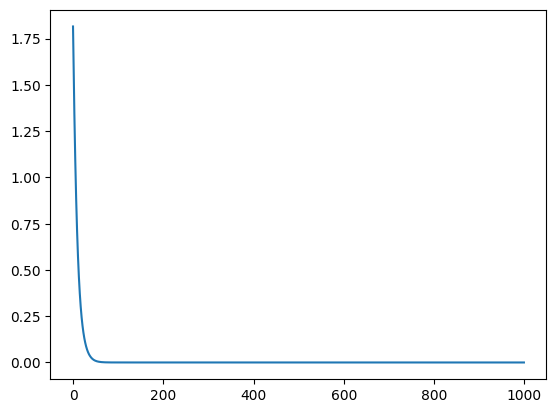

In [55]:
plt.plot(train_losses)

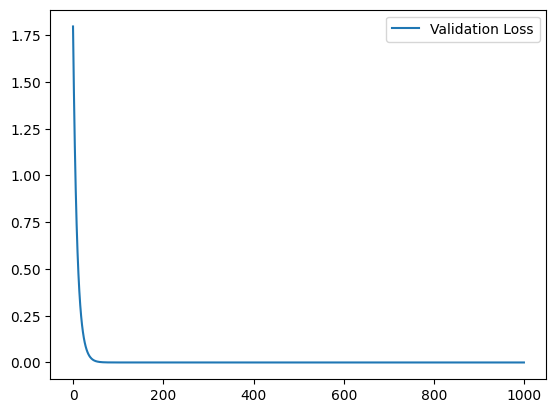

In [56]:
plt.plot(val_losses, label='Validation Loss')
# plt.plot(ae_val_losses, label='AE Validation Loss')
plt.legend()

RuntimeError: unflatten: Provided sizes [1, 28, 28] don't multiply up to the size of dim 1 (64) in the input tensor

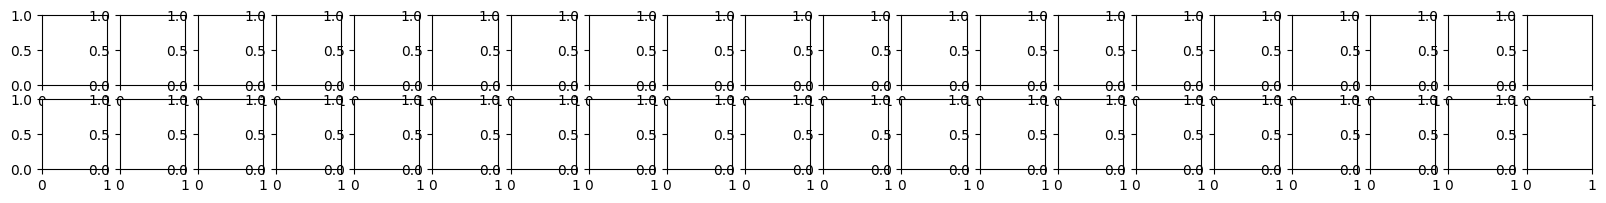

In [57]:
sample_size = 20
idxs = torch.randint(0, len(test_set), (sample_size,))

fig, axes = plt.subplots(2, sample_size, figsize=(sample_size, 2))
for i, idx in enumerate(idxs):
    x, _ = test_set[idx]
    x_hat = model(x.unsqueeze(0))
    axes[0, i].imshow(x.squeeze().cpu(), cmap='gray')
    axes[1, i].imshow(x_hat.squeeze().cpu().detach(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')
plt.show()

In [66]:
def train_1kmnist(
        model,
        train_set,
        val_set,
        n_epochs,
        batch_size,
):
    classifier = nn.Linear(64, 10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        model.train()
        train_loss = 0
        for _, (x, label) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], val_acc=val_accs[-1])

            x = model.encoder(x)
            pred = classifier(x)
            loss = criterion(pred, label)

            optimiser.zero_grad(set_to_none=True)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        model.eval()
        val_loss = 0
        num_correct = 0
        for x, label in val_loader:
            x = model.encoder(x)
            pred = classifier(x)
            loss = criterion(pred, label)
            val_loss += loss.item()
            num_correct += (pred.argmax(1) == label).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(num_correct / len(val_set) * 100)
        
    return train_losses, val_losses, val_accs

In [67]:
c_t_losses, c_v_losses, c_v_accs = train_1kmnist(model, train_set, val_set, EPOCHS, 500)

KeyboardInterrupt: 